# News Articles Recommendation

## 1. Collect Active Twitter Users' Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

#to scrape Twitter
import tweepy
from tweepy import OAuthHandler
 
#warning    
import warnings
warnings.filterwarnings('ignore')

In [2]:
#authorizing twitter api with consumer key and secrets
consumer_key = 'WwzFApr0hzEcMlHqAsxN0qxrK'
consumer_secret = 'TU756bVsmWa9YtIEsKwdCAqnfeqKCo63KvHvQANoPXuPf3CVF4'
access_token = '1354374554-DTnvbTCT9gBqG17ZiLveimyOlhTfiYajJRCvgL8'
access_secret = 'QGnnrOnImC7c7ywQUKQhv9kNyKc31kecy3GaZdTNIMkEm'
 
auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
 
api = tweepy.API(auth)

We can get users who actively retweet news articles from popular news channels' twitter handles

In [3]:
def get_users(twitterNewsChannels,NumberofTweet):
    """This function fetch users who retweet given News handle's tweets 
    
    Input: 
      TwitterNewsChannels - List of news channels' twitter handles
      NumberofTweet = int number of tweet to analyze on this twitter handle
    Return:
      DataFrame of Users ActiveNewsReaders, Popularity, Verified, TotalTweets
      """
    usersFromTweets = pd.DataFrame(columns = ["ActiveNewsReaders","Popularity", "Verified","totalTweets"])
    numberOfUsersMined = 0
    
    for newsChannel in twitterNewsChannels:
        for tweet in api.user_timeline(screen_name = newsChannel, count=NumberofTweet):
            for reTweet in api.retweets(tweet.id):
                
                usersFromTweets.loc[numberOfUsersMined, "ActiveNewsReaders"] = reTweet.user.screen_name
                
                if(reTweet.user.friends_count == 0):
                    usersFromTweets.loc[numberOfUsersMined, "Popularity"] = reTweet.user.followers_count
                else:
                    usersFromTweets.loc[numberOfUsersMined, "Popularity"] = reTweet.user.followers_count/reTweet.user.friends_count
                
                usersFromTweets.loc[numberOfUsersMined, "Verified"] = reTweet.user.verified
                usersFromTweets.loc[numberOfUsersMined, "totalTweets"] = reTweet.user.statuses_count
                
                numberOfUsersMined+=  1
                
                if numberOfUsersMined %100 ==0:
        
                  time.sleep(6)
    return usersFromTweets

To fetch users, let's provide 3 news providers' twitter handles.
- New York Times - @nytimes
- CNN News - @CNN
- Washington Post - @washingtonpost

We will fetch the users who retweeted 50 top tweets of these news providers.

In [4]:
NewsChannelsUsernames = ["nytimes","CNN","washingtonpost"]
usersData = get_users(NewsChannelsUsernames, 25)

Let's see our active news readers

In [5]:
usersData.head()

,ActiveNewsReaders,Popularity,Verified,totalTweets
0,CalebHowe,10.7575,True,57159
1,rsgaddy18,0.677165,False,13221
2,AGRIMMONE,0.396774,False,44192
3,PeterDudley,1.06101,False,24956
4,drdespicable,1.78554,False,62851


In [6]:
# users might retweetted muliple tweets so, we removed the duplicate users
usersData.drop_duplicates(inplace = True)
usersData.shape

(853, 4)

To make sure that all users are authentic let's filter them based on their popularity and their twitter activity.

In [7]:
# Filetered users with tweets > 10 and popularity 
usersData = usersData[(usersData.totalTweets > 10) & (usersData.Popularity > 1)]
usersData.shape

(242, 4)

In [8]:
usersData = usersData.reset_index(drop=True)

Now we have list of active users from which we can get their information. Following function will extract each user's top 20 tweets

In [9]:
def getTweets(user):
    # Get Ten Tweets from the each user
    twitterUser = api.get_user(user)
    
    tweets = api.user_timeline(screen_name = user, count = 10,tweet_mode='extended')
    tentweets = []
    for tweet in tweets:
        if tweet.full_text.startswith("RT @") == True:
            tentweets.append(tweet.retweeted_status.full_text)
        else:
            tentweets.append(tweet.full_text)
       
    return tentweets

In [10]:
vfunc = np.vectorize(getTweets)
usersData["tweets"] = usersData['ActiveNewsReaders'].apply(lambda x: getTweets(x))

In [11]:
usersData.head(10)

,ActiveNewsReaders,Popularity,Verified,totalTweets,tweets
0,CalebHowe,10.7575,True,57159,[It was supposed to be the golden anniversary ...
1,PeterDudley,1.06101,False,24956,[It was supposed to be the golden anniversary ...
2,drdespicable,1.78554,False,62851,"[""We enforce the law without fear or favor bec..."
3,pooleyjd,1.0155,False,11821,[It was supposed to be the golden anniversary ...
4,CcPrakay,2.45868,False,44338,[VIDEO: Confident and fired up: Joe Biden supp...
5,nyt_rt,30.5,False,14626,[It was supposed to be the golden anniversary ...
6,PipkinDebbie,4.60714,False,42855,[FACT CHECK: Traitorous Republicans in DC bloc...
7,laura_lthomp,1.304,False,202055,[Trump and Republicans DO. NOT. CARE. about th...
8,dbly54,1.06015,False,1082,"[@WTOL11Toledo Against it., Joe Biden gave his..."
9,petebashu,1.04742,False,20847,[Meerkats communicate with purring sounds and ...


Since, the tweets are not clean we will have to preprocess them.

## 2. Analyze Users' Tweets

In [12]:
#to preprocess tweets
import nltk
import string
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
ps = nltk.PorterStemmer()
wn = nltk.WordNetLemmatizer()
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) 

words = set(nltk.corpus.words.words())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sohil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Sohil\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Sohil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [21]:
def processTweets(tweets):
    
    #cleaning of tweets
    cleanedTweets = []
    for tweet in tweets:
        tw = re.sub('http\S+', '', tweet) #remove links
        tw = re.sub('RT', '', tw) #remove RT of retweet
        tw = re.sub('@[^\s]+','',tw) #remove usernames 
        tw = "".join([char for char in tw if char not in string.punctuation]) #remove punctuations
        tw = tw.lower() #converting to lowercase letters
        tw = ' '.join([word for word in tw.split() if word not in (stop)]) #removing stop words
        tw = ' '.join([word for word in tw.split() if len(word)>2])
        cleanedTweets.append(tw)

    cleanedTweets = ' '.join(cleanedTweets) #joining all tweets
    
    #tokenization
    ProcessedTweets = nltk.word_tokenize(cleanedTweets) ####################################################
    
    #stemming
    ProcessedTweets = [ps.stem(word) for word in ProcessedTweets]
    
    #lammitization
    ProcessedTweets = [wn.lemmatize(word) for word in ProcessedTweets]
    
    ProcessedTweets = [word for word in ProcessedTweets if len(word)>2]
    
    ProcessedTweets = ' '.join(w for w in ProcessedTweets if w in words)
    
    return ProcessedTweets
        

In [22]:
usersData["ptweets"] = usersData['tweets'].apply(lambda x : processTweets(x))

In [23]:
usersData.head()

,ActiveNewsReaders,Popularity,Verified,totalTweets,tweets,ptweets
0,CalebHowe,10.7575,True,57159,[It was supposed to be the golden anniversary ...,golden rock concert would say that iron stupid...
1,PeterDudley,1.06101,False,24956,[It was supposed to be the golden anniversary ...,golden rock concert savoy cornel savoy ballroo...
2,drdespicable,1.78554,False,62851,"[""We enforce the law without fear or favor bec...",law without fear favor partisan truth opinion ...
3,pooleyjd,1.0155,False,11821,[It was supposed to be the golden anniversary ...,golden rock concert worker letter union oval a...
4,CcPrakay,2.45868,False,44338,[VIDEO: Confident and fired up: Joe Biden supp...,video fire joe support know candid right marke...


## 3. Cluster users according to their interests

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.manifold import MDS
import os

import matplotlib.pyplot as plt

To cluster users based on their twitter contents we need to convert tweets into vectorized form

In [25]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.1,
                                 use_idf=True)

tfidf_matrix = tfidf_vectorizer.fit_transform(usersData.ptweets)

In [26]:
tfidf_matrix.toarray()

array([[0.        , 0.        , 0.        , ..., 0.32567546, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.18566927, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.17908266, 0.        , 0.        , ..., 0.28261028, 0.        ,
        0.        ],
       [0.        , 0.19669807, 0.        , ..., 0.16891501, 0.15734212,
        0.40539631],
       [0.14689308, 0.        , 0.        , ..., 0.11590596, 0.        ,
        0.        ]])

Let's see the Tf-Idf matrix with readers and words

In [27]:
tfidf_matrix.shape

(242, 115)

In [28]:
pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names(), index = usersData.ActiveNewsReaders)

,also,attack,attorney,back,best,black,break,call,campaign,care,...,way,wear,week,white,woman,work,world,would,year,young
ActiveNewsReaders,,,,,,,,,,,,,,,,,,,,,
CalebHowe,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.325675,0.000000,0.000000
PeterDudley,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.185669,0.000000,0.000000
drdespicable,0.000000,0.000000,0.000000,0.164924,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
pooleyjd,0.000000,0.000000,0.000000,0.470407,0.000000,0.000000,0.251045,0.000000,0.000000,0.000000,...,0.241633,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
CcPrakay,0.000000,0.000000,0.000000,0.145851,0.000000,0.000000,0.000000,0.135437,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.134398,0.135437,0.130436,0.000000,0.000000,0.000000,0.000000
nyt_rt,0.000000,0.000000,0.000000,0.000000,0.214427,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.199117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
PipkinDebbie,0.000000,0.155215,0.474971,0.000000,0.000000,0.000000,0.156746,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.533164,0.000000,0.000000
laura_lthomp,0.000000,0.184095,0.000000,0.000000,0.000000,0.000000,0.185912,0.161744,0.000000,0.202723,...,0.000000,0.000000,0.000000,0.160503,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
dbly54,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.146948,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.116398,0.000000


Using this generated Tf-Idf matrix we can cluster the users.

In [29]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)

km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

In [30]:
km.cluster_centers_.argsort()[:, ::-1]

array([[ 61,  47, 113,  64,  30, 111,  76,  35,  88,  49,  54,  86,  12,
         50, 110,  60,  66,  14, 105,  33,  99,  95,  21,  68, 102,  19,
         22,  96,  90,  75,   3,  27, 107,  48, 104,  79,   4,  46,  78,
         97,  13,  73,  41, 100,  72,  59,  92,  42,  37,   1,  52,  18,
        101,  85,  24,  91,  32,  84,  45,  38,  94,  29,  23,   7, 112,
         69,   9,  11,  16, 109,  63,  20,  70,  67,  77,  55,  34,  93,
         83,  62,  58,   5,  82,  98,  56,  51,   0,  65,  31,  10,  53,
        103,  80,  87,  89,  15, 108,  26,  36,  81,  71,  44, 114,  74,
          8,  28,  17,  25,   6,  57, 106,  40,  43,  39,   2],
       [ 98,  58, 108,  71,  15,  76,  52,   2,  25,  64, 114,  11,  47,
         73,  65, 109,  41, 100, 103,  28,  40,  31, 110,  14,  91,  44,
         89,  97,  59,  67,  62, 112,  99,   7,  26,   3,  43,  85, 105,
        113,  88,  95,  30,   1, 104,  61,  37,  57,  96,  75,  80,  55,
          0,  19,  72,  94,   6,  93,  79,  54,  33, 107,  7

In [31]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()
for i in range(num_clusters):
    print ("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print (' %s' % terms[ind])
    print

Top terms per cluster:
Cluster 0:
 new
 like
 year
 one
 get
 world
 say
 great
 take
 look
Cluster 1:
 trump
 nation
 white
 record
 democrat
 say
 make
 attorney
 fire
 one
Cluster 2:
 singleton
 director
 man
 call
 friend
 life
 start
 black
 made
 today
Cluster 3:
 trump
 impeach
 state
 democrat
 would
 campaign
 lie
 may
 new
 say
Cluster 4:
 first
 wear
 day
 week
 last
 need
 even
 world
 spot
 time


To reduce the dimension of Tf-Idf matrix we define error term, distance matrix using cosine similarity

In [32]:
dist = 1 - cosine_similarity(tfidf_matrix)
dist

array([[ 0.00000000e+00,  9.04567695e-01,  8.95600660e-01, ...,
         9.07960767e-01,  9.13179231e-01,  8.89093633e-01],
       [ 9.04567695e-01,  0.00000000e+00,  6.88932771e-01, ...,
         7.71580149e-01,  7.53186739e-01,  6.48422119e-01],
       [ 8.95600660e-01,  6.88932771e-01, -2.22044605e-16, ...,
         7.71012959e-01,  8.95628413e-01,  8.50489687e-01],
       ...,
       [ 9.07960767e-01,  7.71580149e-01,  7.71012959e-01, ...,
         0.00000000e+00,  7.86779576e-01,  6.38597041e-01],
       [ 9.13179231e-01,  7.53186739e-01,  8.95628413e-01, ...,
         7.86779576e-01,  0.00000000e+00,  7.94107208e-01],
       [ 8.89093633e-01,  6.48422119e-01,  8.50489687e-01, ...,
         6.38597041e-01,  7.94107208e-01,  0.00000000e+00]])

In [33]:
titles = usersData.ActiveNewsReaders

Here, we have used Manifold learning for vizualization. High-dimensional datasets can be very difficult to visualize. While data in two or three dimensions can be plotted to show the inherent structure of the data, equivalent high-dimensional plots are much less intuitive. To aid visualization of the structure of a dataset, the dimension must be reduced in some way.

The simplest way to accomplish this dimensionality reduction is by taking a random projection of the data. Though this allows some degree of visualization of the data structure, the randomness of the choice leaves much to be desired. In a random projection, it is likely that the more interesting structure within the data will be lost.

Multidimensional scaling (MDS) seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space.

In [34]:
MDS()
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
pos = mds.fit_transform(dist)
xs, ys = pos[:, 0], pos[:, 1]

Plotting users based on their clusters

In [35]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2', 
                 3: 'Cluster 3', 
                 4: 'Cluster 4'}

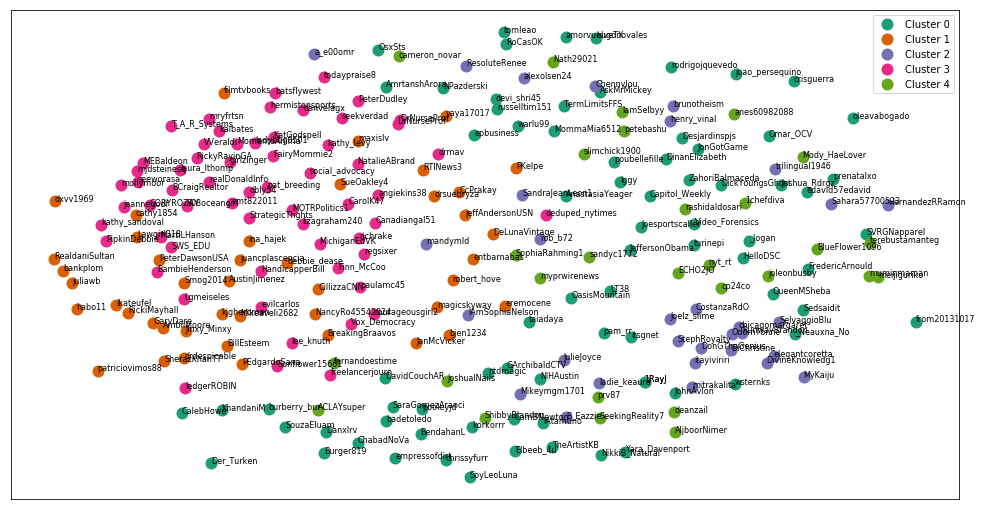

In [36]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1) 
for i in range(len(df)):
    ax.text(df.ix[i]['x'], df.ix[i]['y'], df.ix[i]['title'], size=8)  

plt.show()

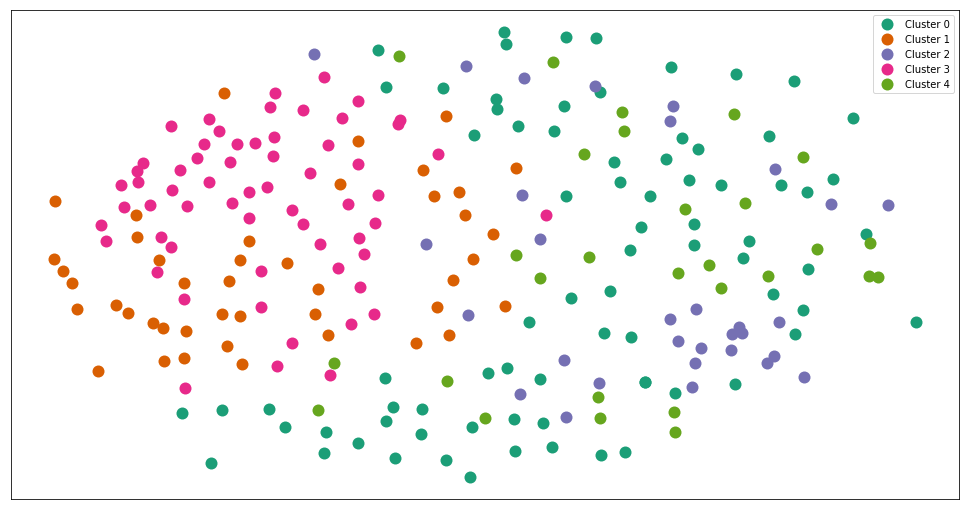

In [37]:
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles.values)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',         # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',        # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)    
plt.show()

In [38]:
#adding cluster labels in the usersData 
usersData['cluster'] = clusters

In [39]:
usersData.head()

,ActiveNewsReaders,Popularity,Verified,totalTweets,tweets,ptweets,cluster
0,CalebHowe,10.7575,True,57159,[It was supposed to be the golden anniversary ...,golden rock concert would say that iron stupid...,0
1,PeterDudley,1.06101,False,24956,[It was supposed to be the golden anniversary ...,golden rock concert savoy cornel savoy ballroo...,3
2,drdespicable,1.78554,False,62851,"[""We enforce the law without fear or favor bec...",law without fear favor partisan truth opinion ...,1
3,pooleyjd,1.0155,False,11821,[It was supposed to be the golden anniversary ...,golden rock concert worker letter union oval a...,0
4,CcPrakay,2.45868,False,44338,[VIDEO: Confident and fired up: Joe Biden supp...,video fire joe support know candid right marke...,1


## 4. Perform Sentiment Analysis and Topic Modelling

In [40]:
# Import required packages
import logging
import pyLDAvis.gensim
from numpy import array
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.models.wrappers import LdaMallet
from gensim.corpora.dictionary import Dictionary
from gensim.models import Phrases

import os

C:\Users\Sohil\Anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


Let's find bigrams and trigrams which appear at least 10 times in the corpus

In [41]:
docs = array(usersData['ptweets'].apply(lambda x: x.split()))

bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

In [42]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

Let's create a dictionary representation of the documents and remove rare and common tokens

In [43]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 418
Number of documents: 242
[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1)]]


In [44]:
usersData['corpus'] = corpus
usersData['docs'] = docs
#create unique list of names
UniqueNames = usersData['cluster'].unique()

In [45]:
#create a data frame dictionary to store data frames
DataFrameDict = {elem : pd.DataFrame for elem in UniqueNames}
docscluster={elem : pd.DataFrame for elem in UniqueNames}
corpuscluster={elem : pd.DataFrame for elem in UniqueNames}
dictionarycluster={elem : pd.DataFrame for elem in UniqueNames}

In [46]:
for key in DataFrameDict.keys():
    DataFrameDict[key] = usersData[:][usersData.cluster == key]
    docscluster[key]=usersData['docs'][usersData.cluster == key]
    corpuscluster[key]=usersData['corpus'][usersData.cluster == key]
    dictionarycluster[key]=Dictionary(docscluster[key])

In [47]:
os.environ['PATH'] += ":/usr/local/go/bin"

In [49]:
os.environ['MALLET_HOME'] = 'C:\\users\\Sohil\\AppData\\Local\\Temp\\mallet-2.0.8'

mallet_path = 'C:\\users\\Sohil\\AppData\\Local\\Temp\\mallet-2.0.8\\bin\\mallet'
ldamallet = LdaMallet(mallet_path, corpus = corpus, id2word = dictionary, iterations = 30)

# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# mallet_path = "/mallet-2.0.8/bin/mallet" # update this path

ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=26, id2word=dictionary)

Let's compute coherence score.

In [50]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)


Coherence Score:  0.3808507995298155


Function to loop computing coherence measures for tuning LDAMallet model

In [51]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:ocs
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [52]:
# Function to loop computing coherence measures for tuning LDAMallet model
#Used c_v parameter as method for computing coherence values
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

Running and storing LDA models. Arbitrarily set minimum number of topic for each cluster=2, maximum number of topics=6

In [53]:
model_list={elem : pd.DataFrame for elem in UniqueNames }
coherence_values={ elem : pd.DataFrame for elem in UniqueNames}
for i in np.arange(num_clusters):
    model_list[i], coherence_values[i] = compute_coherence_values(dictionary=dictionarycluster[i], corpus=corpuscluster[i], texts=docscluster[i], start=2, limit=6, step=1)

In [54]:
# Print the coherence scores
import math
best_value=np.array([])
optimal_model={elem : pd.DataFrame for elem in UniqueNames }
for i in np.arange(num_clusters):
    coherence_values[i]=[value for value in coherence_values[i] if not math.isnan(value)]
    best_value=np.append(best_value, np.amax(coherence_values[i])) 
    t=int(np.argmax(coherence_values[i]))
    optimal_model[i]=model_list[i][t]
    print("Cluster=",i,"has optimal number of topics as", t+2)#######################################################

Cluster= 0 has optimal number of topics as 2
Cluster= 1 has optimal number of topics as 4
Cluster= 2 has optimal number of topics as 5
Cluster= 3 has optimal number of topics as 5
Cluster= 4 has optimal number of topics as 2


print coherence values for all tuned lda models in each cluster

In [55]:
coherence_values

{0: [0.5581086835717872,
  0.5363190049077865,
  0.5296812867271252,
  0.5317153924273447],
 3: [0.46422126543802217,
  0.4862767731238797,
  0.5010481593713847,
  0.5318003275114555],
 1: [0.4913310029460357,
  0.4733270215661807,
  0.5145671231608948,
  0.47696479865452907],
 4: [0.6530753939812128,
  0.5920089196493027,
  0.5682624408115534,
  0.6037601531423059],
 2: [0.5026788016218592,
  0.5262277742304051,
  0.5251918929865611,
  0.5434790520133268]}

In [56]:
optimal_model[i].print_topics(num_words=4)

[(0, '0.038*"posit" + 0.036*"pour" + 0.031*"protest" + 0.028*"nation"'),
 (1,
  '0.053*"partnership" + 0.029*"uniform" + 0.027*"expert_train" + 0.024*"answer"')]

Visualize Tuning process. The optimal model would select as many number of topics which maximizes the coherence value.

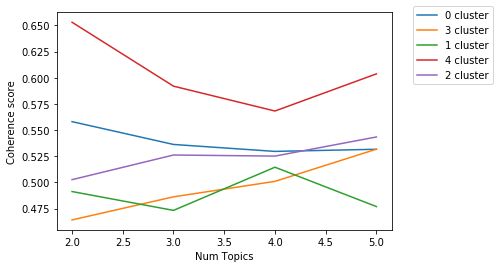

In [57]:
import matplotlib.pyplot as plt
limit=6; start=2; step=1;
x={elem:list(range(start, limit, step)) for elem in (UniqueNames)}
for key in x.keys():
    plt.plot(x[key],coherence_values[key], label= str(key)+ ' cluster') 
    plt.xlabel("Num Topics")
    plt.ylabel("Coherence score")
    
plt.legend(loc='best',bbox_to_anchor=(1.05, 1.05))
#plt.show()
plt.savefig('Coherence Sscor.png',bbox_inches='tight')

Function to analyze the developed topic models on unseen corpus of texts (in our case News articles)

In [58]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


#### Sentiment Analysis using Textblob

In [59]:
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import nltk

Create Dataframe dictionary for polarity and subjectivity values vis-a-vis each cluster


In [72]:
polaritycluster={elem : pd.DataFrame for elem in UniqueNames}
subjectivitycluster={elem : pd.DataFrame for elem in UniqueNames}
for i in DataFrameDict.keys():
    polaritycluster[i]=TextBlob(' '.join(DataFrameDict[i]['tweets'].astype('str'))).sentiment.polarity#######################################
    subjectivitycluster[i]=TextBlob(' '.join(DataFrameDict[i]['tweets'].astype('str'))).sentiment.subjectivity################################


Print polarity clusters for each cluster

In [73]:
polaritycluster

{0: 0.12918745144366645,
 3: 0.08543298465788765,
 1: 0.04996122149732092,
 4: 0.1038298619806885,
 2: 0.09812355593886392}

Print subjectivity score for each cluster

In [74]:
subjectivitycluster

{0: 0.4497340472314643,
 3: 0.47042174322327307,
 1: 0.46619483354274166,
 4: 0.41950831614054745,
 2: 0.4725892970079022}

Visualize the topics

In [75]:
 #Visualize the topics
pyLDAvis.enable_notebook()
lda_model2 = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model[1])
vis2 = pyLDAvis.gensim.prepare(lda_model2, corpuscluster[1], dictionarycluster[1])
vis2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.332910  0.205533       1        1  26.214258
0     -0.349754  0.222251       2        1  25.832400
3     -0.035124 -0.362148       3        1  24.463063
1      0.051967 -0.065636       4        1  23.490280, topic_info=     Category       Freq             Term      Total  loglift  logprob
term                                                                  
159   Default  33.000000             chip  33.000000  30.0000  30.0000
100   Default  28.000000             hard  28.000000  29.0000  29.0000
135   Default  23.000000           theyll  23.000000  28.0000  28.0000
136   Default  23.000000            today  23.000000  27.0000  27.0000
102   Default  21.000000             home  21.000000  26.0000  26.0000
352   Default  19.000000            union  19.000000  25.0000  25.0000
218   Default  24.000000       accomplish  24.000000  24.0000  24.0000
41    Default  17.000000           resign  17.000000  23.0000  23.0000
65    Default  17.000000            annoy  17.000000  22.0000  22.0000
48    Default  17.000000             side  17.000000  21.0000  21.0000
42    Default  18.000000              rip  18.000000  20.0000  20.0000
412   Default  17.000000           writer  17.000000  19.0000  19.0000
45    Default  15.000000              sad  15.000000  18.0000  18.0000
55    Default  15.000000              tri  15.000000  17.0000  17.0000
168   Default  14.000000             drew  14.000000  16.0000  16.0000
67    Default  14.000000              bad  14.000000  15.0000  15.0000
26    Default  14.000000             land  14.000000  14.0000  14.0000
15    Default  14.000000            fleet  14.000000  13.0000  13.0000
158   Default  13.000000      china_trade  13.000000  12.0000  12.0000
23    Default  13.000000              huh  13.000000  11.0000  11.0000
85    Default  12.000000         firework  12.000000  10.0000  10.0000
162   Default  12.000000            close  12.000000   9.0000   9.0000
19    Default  12.000000           govern  12.000000   8.0000   8.0000
9     Default  12.000000         distract  12.000000   7.0000   7.0000
266   Default  12.000000           sexual  12.000000   6.0000   6.0000
151   Default  12.000000              bar  12.000000   5.0000   5.0000
146   Default  12.000000            white  12.000000   4.0000   4.0000
63    Default  11.000000            wrong  11.000000   3.0000   3.0000
70    Default  11.000000              big  11.000000   2.0000   2.0000
36    Default  11.000000          opinion  11.000000   1.0000   1.0000
...       ...        ...              ...        ...      ...      ...
260    Topic4   7.390495       model_wear   7.390495   1.4486  -4.1846
267    Topic4   2.463498   sexual_assault   2.463498   1.4486  -5.2832
156    Topic4   9.853994           butler   9.853994   1.4486  -3.8969
137    Topic4   6.158746         tomorrow   6.158746   1.4486  -4.3669
273    Topic4   1.231749         swimsuit   1.231749   1.4486  -5.9764
41     Topic4  17.244489           resign  17.244489   1.4486  -3.3373
14     Topic4   9.853994             fire   9.853994   1.4486  -3.8969
21     Topic4   3.695248             hear   3.695248   1.4486  -4.8777
24     Topic4   3.695248             hurt   3.695248   1.4486  -4.8777
25     Topic4   4.926997          instant   4.926997   1.4486  -4.5901
32     Topic4   4.926997           matter   4.926997   1.4486  -4.5901
34     Topic4   9.853994         obstruct   9.853994   1.4486  -3.8969
352    Topic4  19.707987            union  19.707987   1.4486  -3.2038
65     Topic4  17.244489            annoy  17.244489   1.4486  -3.3373
70     Topic4  11.085743              big  11.085743   1.4486  -3.7791
316    Topic4  11.085743          launder  11.085743   1.4486  -3.7791
36     Topic4  11.085743          opinion  11.085743   1.4486  -3.7791
371    Topic4  11.085743            debut  11.085743   1.4486  -3.7791
403    Topic

In [76]:
pyLDAvis.save_html(vis2, 'lda1.html') #save the visualization

## 5. Collect and Analyze News articles

In [77]:
# Using newspaper3k package
import newspaper
from newspaper import Article

# for similarity measure
from sklearn.metrics.pairwise import cosine_similarity

C:\Users\Sohil\Anaconda3\lib\site-packages\lxml\html\_setmixin.py:1: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import MutableSet


We will suggest an article from following three News Service Providers
- CNN
- Washington Post
- New York Times

In [95]:
cnn_paper = newspaper.build('https://www.cnn.com/') #CNN paper
WP_paper = newspaper.build('https://www.washingtonpost.com',language='en') # WP paper 
NYT_paper = newspaper.build('https://www.nytimes.com',language='en') # NYT paper

C:\Users\Sohil\Anaconda3\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)
C:\Users\Sohil\Anaconda3\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)
C:\Users\Sohil\Anaconda3\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see the discussion on issue #2266. (This warning should only appear once.)
  DeprecationWarning)
C:\Users\Sohil\Anaconda3\lib\site-packages\requests\utils.py:439: DeprecationWarning: In requests 3.0, get_encodings_from_content will be removed. For more information, please see t

#### Extracting recent articles 

In [96]:
import pandas as pd
df_text = pd.DataFrame(columns=['Link','text'])
for article in cnn_paper.articles:
    link = article.url
    try:
        
        article.download()
        article.parse()
        article.nlp()
        article.text
        temp={'Link':link,
              'text':article.text}
        df_text= df_text.append(temp,ignore_index=True)
        
    except:
        pass
for article in WP_paper.articles:
    link = article.url
    try:
        
        article.download()
        article.parse()
        article.nlp()
        article.text
        temp={'Link':link,
              'text':article.text}
        df_text= df_text.append(temp,ignore_index=True)
        
    except:
        pass
for article in NYT_paper.articles:
    link = article.url
    try:
        
        article.download()
        article.parse()
        article.nlp()
        article.text
        temp={'Link':link,
              'text':article.text}
        df_text= df_text.append(temp,ignore_index=True)
        
    except:
        pass 

Let's perform cleaning on news articles and for that we can use previous processTweets function which is designed to clean tweets

In [97]:
df_text['text'] = df_text['text'].apply(lambda x : processTweets(x))

Let's find out bigrams and trigrams

In [98]:
docs = array(df_text['text'].apply(lambda x : x.split())) ####################################################################
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

In [99]:
# Remove rare and common tokens 
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)

#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 0
Number of documents: 6


Let's calculate Sentiment score for news articles

In [100]:
pol=[TextBlob(' '.join(df_text.iloc[i,1])).sentiment.polarity for i in range(df_text.shape[0])]
sub=[TextBlob(' '.join(df_text.iloc[i,1])).sentiment.subjectivity for i in range(df_text.shape[0])]
df_text['pol']=pol
df_text['sub']=sub

In [101]:
# Function to analyze the developed topic models on unseen corpus of texts (in our case News articles)
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=docs):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']
    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

Let's assign topic modelling scores to every news articles for each of the optimal topic model developed

In [102]:
# The percent contribution of each topic model considered as metric to assign topic score
df_topic_sents_keywords={elem : pd.DataFrame for elem in UniqueNames}
topicss=pd.DataFrame()
for i in range(len(UniqueNames)):
    mod=gensim.models.wrappers.ldamallet.malletmodel2ldamodel(optimal_model[i])
    temp={'cluster':i,
         'model':mod}
    topicss=topicss.append(temp, ignore_index=True)
    df_topic_sents_keywords[i] = format_topics_sentences(ldamodel=mod, corpus=corpus, texts=docs)
    
    # Centre the percent contribution by subtracting the mean. This standardises topic score
    df_topic_sents_keywords[i]['Diff']= df_topic_sents_keywords[i]['Perc_Contribution']-np.mean(df_topic_sents_keywords[i]['Perc_Contribution'])

Let's compute sentiment score using cosine similarity between cluster scores and scores obtained from news articles


In [103]:
sentiment={elem: pd.DataFrame for elem in UniqueNames}
subjectivit={elem: pd.DataFrame for elem in UniqueNames}
w1=0.8 # Topic modelling weight
w2=0.2 # Sentiment score weight
for i in range(len(UniqueNames)):
    sentiment[i]=cosine_similarity(np.array(df_text.iloc[:, 2]).reshape(-1, 1),np.array([polaritycluster[i]]).reshape(-1, 1))
    subjectivit[i]=cosine_similarity(np.array(df_text.iloc[:, 2]).reshape(-1, 1),np.array([subjectivitycluster[i]]).reshape(-1, 1))
    df_topic_sents_keywords[i]['Polarity']=sentiment[i]
    df_topic_sents_keywords[i]['Subjectivity']=subjectivit[i]
    df_topic_sents_keywords[i]['Metric']=w1*df_topic_sents_keywords[i]['Diff']+w2/2*(df_topic_sents_keywords[i]['Polarity']+df_topic_sents_keywords[i]['Subjectivity'])

## 6. Get user’s Twitter handle & Recommend news articles

In [104]:
# Recommendation dataframe
recommend=pd.DataFrame()
metric_value=pd.DataFrame()
rec=np.array([])
for i in range(len(docs)):
    for j in range(len(UniqueNames)):
        rec=np.append(rec, df_topic_sents_keywords[j].iloc[i,7])
        
    recommend=recommend.append(pd.Series(np.argmax(rec)),ignore_index=True)
    metric_value=metric_value.append(pd.Series(np.amax(rec)),ignore_index=True)
    rec=np.array([])

In [105]:
recommend['metric']=metric_value
recommend['url']=df_text['Link']

#np.array([recommend,metric_value])
recommend #0 is cluster group

,0,metric,url
0,2.0,2.220446e-17,http://washingtonpost.com/crime-law/2019/04/30...
1,2.0,2.220446e-17,https://www.washingtonpost.com/sports/national...
2,2.0,2.220446e-17,https://www.nytimes.com/2019/04/29/opinion/tru...
3,2.0,2.220446e-17,http://www.nytimes.com/2019/04/29/opinion/trum...
4,2.0,2.220446e-17,https://cn.nytimes.com/technology/20190430/chi...
5,2.0,2.220446e-17,https://cn.nytimes.com/business/20190424/boein...


In [106]:
recommend.sort_values(by=['metric', 0], ascending ='False')

,0,metric,url
0,2.0,2.220446e-17,http://washingtonpost.com/crime-law/2019/04/30...
1,2.0,2.220446e-17,https://www.washingtonpost.com/sports/national...
2,2.0,2.220446e-17,https://www.nytimes.com/2019/04/29/opinion/tru...
3,2.0,2.220446e-17,http://www.nytimes.com/2019/04/29/opinion/trum...
4,2.0,2.220446e-17,https://cn.nytimes.com/technology/20190430/chi...
5,2.0,2.220446e-17,https://cn.nytimes.com/business/20190424/boein...


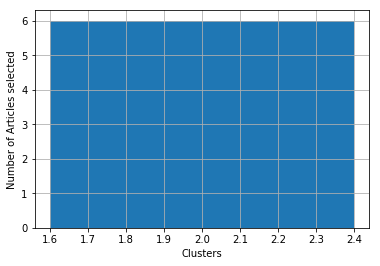

In [107]:
import seaborn as sns
plt.bar(recommend[0].value_counts().index,recommend[0].value_counts())
plt.grid()
plt.xlabel('Clusters')
plt.ylabel('Number of Articles selected')
plt.savefig('Percentage Recommend.png',bbox_inches='tight')

In [ ]:
df_topic_sents_keywords